In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn import linear_model
from numpy import genfromtxt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier   
from sklearn.decomposition import PCA
from sklearn import tree
from imblearn.over_sampling import ADASYN 
from collections import Counter
from fancyimpute import KNN,BiScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn import svm
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from  numpy  import   array
from  numpy  import  argmax
from  sklearn.model_selection import train_test_split

from Codebase import Valuestandard

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score as AUC
from  sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import  metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import confusion_matrix as CM,precision_score as P,recall_score as R

Using TensorFlow backend.


In [2]:
data = pd.read_csv('stroke1905.csv')

In [3]:
x = data.drop(columns=['mrs'])
y = data["mrs"].copy()

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 0)

In [5]:
skip_list = [6,8,9,10,11,12,13,14,15,16,17,18,19] 
onehot_list = [20] 
categories_list = [5]

In [6]:
VS = Valuestandard(skip_list, onehot_list, categories_list, Skip=True, OneHot=True)

In [7]:
x_train = x_train.reset_index(drop=True)

In [8]:
VS.fit_transform(x_train)

In [9]:
x_train_standard = VS.standard_data_1()

In [10]:
x_test = x_test.reset_index(drop=True)

In [11]:
VS.transform(x_test)

In [12]:
x_test_standard = VS.standard_data_2()

In [13]:
from sklearn.linear_model import LassoCV
clf1 = LassoCV(alphas = [0.005]).fit(x_train_standard, y_train)
importance1 = np.abs(clf1.coef_)
print(importance1)

[0.08213398 0.08335377 0.02617992 0.01874061 0.03669817 0.00308103
 0.         0.         0.         0.         0.00873415 0.
 0.02179919 0.         0.         0.00192774 0.         0.0142848
 0.         0.05644978 0.01882146 0.         0.07628168 0.
 0.        ]


In [14]:
m = np.flatnonzero(importance1).tolist()
m

[0, 1, 2, 3, 4, 5, 10, 12, 15, 17, 19, 20, 22]

In [15]:
x_train_standard1 = x_train_standard.iloc[:,m]

In [16]:
x_test_standard1 = x_test_standard.iloc[:,m]

In [17]:
x_train_standard1.to_csv('x_train_standard1.csv', index=False)
x_test_standard1.to_csv('x_test_standard1.csv', index=False)

# Optimal_Cutoff

In [18]:
##Find best threshold
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    optimal_point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, optimal_point

##compute ROC_AUC
def ROC(y_train, y_prob):
    """
    Receiver_Operating_Characteristic, ROC
    :param y_train: (n, )
    :param y_prob: (n, )
    :return: fpr, tpr, roc_auc, optimal_threshold, optimal_point
    """
    fpr, tpr, thresholds = roc_curve(y_train, y_prob)
    roc_auc = auc(fpr, tpr)
    optimal_threshold, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    return fpr, tpr, roc_auc, optimal_threshold, optimal_point

##Predicting results using optimal thresholds
def new_pred(proba,optimal_threshold):
    proba_model = np.copy(proba)
    pred_proba = proba_model
    pred_proba[pred_proba < optimal_threshold.round(3)] = 0
    pred_proba[pred_proba >= optimal_threshold.round(3)] = 1
    pred = pred_proba
    return pred

LR

In [19]:
import itertools
lr = LR(C=1,penalty="l2", solver = "liblinear", max_iter=100,class_weight = {0:1,1:4},random_state = 10)
lr.fit(x_train_standard1,y_train)
y_pred_lr = lr.predict_proba(x_train_standard1)

In [20]:
print("AUC",AUC(y_train, y_pred_lr[:, 1]))

AUC 0.7630262756812778


In [21]:
##Predicting training set probabilities
prediction_train_proba_lr = lr.predict_proba(x_train_standard1)
# ##Predicting training set results
# prediction_train_lr = lr.predict(x_train_standard1)

fpr_train_lr, tpr_train_lr, auc_train_lr, optimal_threshold_lr, optimal_point = ROC(y_train,y_prob = prediction_train_proba_lr[:,1])

print('optimal_threshold:%.3f'%optimal_threshold_lr)
print(optimal_point)

optimal_threshold:0.526
[0.32680851063829786, 0.7335243553008596]


In [22]:
##Predicting test set probabilities
prediction_test_proba_lr = lr.predict_proba(x_test_standard1)
# ##Predicting test set results
# prediction_test_lr = lr.predict(x_test_standard1)

##compute fpr,tpr(recall)
fpr_test_lr, tpr_test_lr, thresholds = roc_curve(y_test, prediction_test_proba_lr[:,1])
##compute ROC_AUC
auc_test_lr = auc(fpr_test_lr, tpr_test_lr)


#Apply thresholds to define the predicted outcome
prediction_test_lr = new_pred(proba = prediction_test_proba_lr[:,1], optimal_threshold = optimal_threshold_lr)

print('auc_train_lr:%.3f'%auc_train_lr)
print('auc_test_lr:%.3f'%auc_test_lr)

a=confusion_matrix(y_test,prediction_test_lr)
print(a)
print('sensitivity:%.3f'%(a[1,1]/(a[1,1]+a[1,0])))
print('specifity:%.3f'%(a[0,0]/(a[0,0]+a[0,1])))
print('PPV:%.3f'%(a[1,1]/(a[1,1]+a[0,1])))
print('NPV:%.3f'%(a[0,0]/(a[0,0]+a[1,0])))

print('accuracy:%.3f'%accuracy_score(y_test, prediction_test_lr)) 
print('precision:%.3f'%precision_score(y_test, prediction_test_lr)) 
print('recall:%.3f'%recall_score(y_test, prediction_test_lr)) 
print('F1:%.3f'%f1_score(y_test, prediction_test_lr))  

auc_train_lr:0.763
auc_test_lr:0.766
[[182 101]
 [ 21  77]]
sensitivity:0.786
specifity:0.643
PPV:0.433
NPV:0.897
accuracy:0.680
precision:0.433
recall:0.786
F1:0.558


In [23]:
from Codebase import ConfusionMatrix
from Codebase import PlotROC
from Codebase import PlotDCA
from Codebase import DelongTest
from Codebase import CompareModel

RFC

In [24]:
# 'n_estimators':range(10,71,10)
# 'n_estimators': [10,50,100,200,500,1000]    

In [25]:
rfc1 = RandomForestClassifier(max_depth=3,min_samples_split=50,min_samples_leaf=10,
                              class_weight = {0:1,1:4},n_estimators=200,random_state = 10)
rfc1.fit(x_train_standard1,y_train.ravel())

RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=3,
                       min_samples_leaf=10, min_samples_split=50,
                       n_estimators=200, random_state=10)

In [26]:
prediction_train_proba_rfc = rfc1.predict_proba(x_train_standard1)

# prediction_train_rfc = rfc1.predict(x_train_standard1)

fpr_train_rfc, tpr_train_rfc, auc_train_rfc, optimal_threshold_rfc, optimal_point_rfc = ROC(y_train,y_prob = prediction_train_proba_rfc[:,1])

print('optimal_threshold:%.3f'%optimal_threshold_rfc)
print(optimal_point_rfc)

optimal_threshold:0.498
[0.39063829787234045, 0.8252148997134671]


In [27]:

prediction_test_proba_rfc = rfc1.predict_proba(x_test_standard1)

# prediction_test_rfc = rfc1.predict(x_test_standard1)


fpr_test_rfc, tpr_test_rfc, thresholds = roc_curve(y_test, prediction_test_proba_rfc[:,1])

auc_test_rfc = auc(fpr_test_rfc, tpr_test_rfc)



prediction_test_rfc = new_pred(proba = prediction_test_proba_rfc[:,1], optimal_threshold = optimal_threshold_rfc)

print('auc_train_rfc:%.3f'%auc_train_rfc)
print('auc_test_rfc:%.3f'%auc_test_rfc)

a=confusion_matrix(y_test,prediction_test_rfc)
print(a)
print('sensitivity:%.3f'%(a[1,1]/(a[1,1]+a[1,0])))
print('specifity:%.3f'%(a[0,0]/(a[0,0]+a[0,1])))
print('PPV:%.3f'%(a[1,1]/(a[1,1]+a[0,1])))
print('NPV:%.3f'%(a[0,0]/(a[0,0]+a[1,0])))

print('accuracy:%.3f'%accuracy_score(y_test, prediction_test_rfc)) 
print('precision:%.3f'%precision_score(y_test, prediction_test_rfc)) 
print('recall:%.3f'%recall_score(y_test, prediction_test_rfc)) 
print('F1:%.3f'%f1_score(y_test, prediction_test_rfc))  

auc_train_rfc:0.783
auc_test_rfc:0.755
[[168 115]
 [ 19  79]]
sensitivity:0.806
specifity:0.594
PPV:0.407
NPV:0.898
accuracy:0.648
precision:0.407
recall:0.806
F1:0.541


SVM

In [28]:
from sklearn import svm
svm=svm.SVC(C=0.5,gamma=0.01,kernel='rbf',probability = True,class_weight = {0:1,1:4},random_state=20)
svm.fit(x_train_standard1,y_train.ravel())
y_pred_svm = svm.predict(x_train_standard1)
y_pred_svm_proba = svm.predict_proba(x_train_standard1)

In [29]:

prediction_train_proba_svm = svm.predict_proba(x_train_standard1)

# prediction_train_svm = svm.predict(x_train_standard1)

fpr_train_svm, tpr_train_svm, auc_train_svm, optimal_threshold_svm, optimal_point_svm = ROC(y_train,y_prob = prediction_train_proba_svm[:,1])

print('optimal_threshold:%.3f'%optimal_threshold_svm)
print(optimal_point_svm)

optimal_threshold:0.249
[0.2774468085106383, 0.7020057306590258]


In [30]:

prediction_test_proba_svm = svm.predict_proba(x_test_standard1)

# prediction_test_svm = svm.predict(x_test_standard1)

fpr_test_svm, tpr_test_svm, thresholds = roc_curve(y_test, prediction_test_proba_svm[:,1])

auc_test_svm = auc(fpr_test_svm, tpr_test_svm)



prediction_test_svm = new_pred(proba = prediction_test_proba_svm[:,1], optimal_threshold = optimal_threshold_svm)

print('auc_train_svm:%.3f'%auc_train_svm)
print('auc_test_svm:%.3f'%auc_test_svm)

a=confusion_matrix(y_test,prediction_test_svm)
print(a)
print('sensitivity:%.3f'%(a[1,1]/(a[1,1]+a[1,0])))
print('specifity:%.3f'%(a[0,0]/(a[0,0]+a[0,1])))
print('PPV:%.3f'%(a[1,1]/(a[1,1]+a[0,1])))
print('NPV:%.3f'%(a[0,0]/(a[0,0]+a[1,0])))

print('accuracy:%.3f'%accuracy_score(y_test, prediction_test_svm)) 
print('precision:%.3f'%precision_score(y_test, prediction_test_svm)) 
print('recall:%.3f'%recall_score(y_test, prediction_test_svm)) 
print('F1:%.3f'%f1_score(y_test, prediction_test_svm))  

auc_train_svm:0.767
auc_test_svm:0.762
[[201  82]
 [ 25  73]]
sensitivity:0.745
specifity:0.710
PPV:0.471
NPV:0.889
accuracy:0.719
precision:0.471
recall:0.745
F1:0.577


XGB

In [31]:
xgb = XGBClassifier(max_depth=2,n_estimators =20,gamma=0.5,min_child_weight=1,objective= 'binary:logistic',random_state = 10)
xgb.fit(x_train_standard1,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=0, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:

prediction_train_proba_xgb = xgb.predict_proba(x_train_standard1)

# prediction_train_xgb = xgb.predict(x_train_standard1)

fpr_train_xgb, tpr_train_xgb, auc_train_xgb, optimal_threshold_xgb, optimal_point_xgb = ROC(y_train,y_prob = prediction_train_proba_xgb[:,1])

print('optimal_threshold:%.3f'%optimal_threshold_xgb)
print(optimal_point_xgb)

optimal_threshold:0.225
[0.2927659574468085, 0.7908309455587392]


In [33]:

prediction_test_proba_xgb = xgb.predict_proba(x_test_standard1)

# prediction_test_xgb = xgb.predict(x_test_standard1)


fpr_test_xgb, tpr_test_xgb, thresholds = roc_curve(y_test, prediction_test_proba_xgb[:,1])

auc_test_xgb = auc(fpr_test_xgb, tpr_test_xgb)



prediction_test_xgb = new_pred(proba = prediction_test_proba_xgb[:,1], optimal_threshold = optimal_threshold_xgb)

print('auc_train_xgb:%.3f'%auc_train_xgb)
print('auc_test_xgb:%.3f'%auc_test_xgb)

a=confusion_matrix(y_test,prediction_test_xgb)
print(a)
print('sensitivity:%.3f'%(a[1,1]/(a[1,1]+a[1,0])))
print('specifity:%.3f'%(a[0,0]/(a[0,0]+a[0,1])))
print('PPV:%.3f'%(a[1,1]/(a[1,1]+a[0,1])))
print('NPV:%.3f'%(a[0,0]/(a[0,0]+a[1,0])))

print('accuracy:%.3f'%accuracy_score(y_test, prediction_test_xgb)) 
print('precision:%.3f'%precision_score(y_test, prediction_test_xgb)) 
print('recall:%.3f'%recall_score(y_test, prediction_test_xgb)) 
print('F1:%.3f'%f1_score(y_test, prediction_test_xgb))  

auc_train_xgb:0.812
auc_test_xgb:0.749
[[193  90]
 [ 29  69]]
sensitivity:0.704
specifity:0.682
PPV:0.434
NPV:0.869
accuracy:0.688
precision:0.434
recall:0.704
F1:0.537


DNN

In [34]:
import keras as K
from keras import layers
from keras.layers import Input,Dense,Activation,Dropout
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from  tensorflow.keras.models import load_model
from keras.optimizers import SGD,Nadam

In [35]:
#save
#model.save('stroke_dnnmodel')

In [36]:
stroke = load_model('stroke_dnnmodel')

In [37]:
n=stroke.predict(x_train_standard1)
n

array([[0.79804486],
       [0.70916176],
       [0.4328285 ],
       ...,
       [0.838043  ],
       [0.17504893],
       [0.49154478]], dtype=float32)

In [38]:

prediction_train_proba_dnn = stroke.predict(x_train_standard1)

# prediction_train_dnn = stroke_dnnmodel.predict(x_train_standard1)

fpr_train_dnn, tpr_train_dnn, auc_train_dnn, optimal_threshold_dnn, optimal_point_dnn = ROC(y_train,y_prob = prediction_train_proba_dnn)

print('optimal_threshold:%.3f'%optimal_threshold_dnn)
print(optimal_point_dnn)

optimal_threshold:0.601
[0.29106382978723405, 0.7249283667621776]


In [39]:

prediction_test_proba_dnn = stroke.predict(x_test_standard1)

# prediction_test_dnn = stroke.predict(x_test_standard1)

fpr_test_dnn, tpr_test_dnn, thresholds = roc_curve(y_test, prediction_test_proba_dnn)

auc_test_dnn = auc(fpr_test_dnn, tpr_test_dnn)



prediction_test_dnn = new_pred(proba = prediction_test_proba_dnn, optimal_threshold = optimal_threshold_dnn)

print('auc_train_dnn:%.3f'%auc_train_dnn)
print('auc_test_dnn:%.3f'%auc_test_dnn)

a=confusion_matrix(y_test,prediction_test_dnn)
print(a)
print('sensitivity:%.3f'%(a[1,1]/(a[1,1]+a[1,0])))
print('specifity:%.3f'%(a[0,0]/(a[0,0]+a[0,1])))
print('PPV:%.3f'%(a[1,1]/(a[1,1]+a[0,1])))
print('NPV:%.3f'%(a[0,0]/(a[0,0]+a[1,0])))

print('accuracy:%.3f'%accuracy_score(y_test, prediction_test_dnn)) 
print('precision:%.3f'%precision_score(y_test, prediction_test_dnn)) 
print('recall:%.3f'%recall_score(y_test, prediction_test_dnn)) 
print('F1:%.3f'%f1_score(y_test, prediction_test_dnn))  

auc_train_dnn:0.783
auc_test_dnn:0.759
[[190  93]
 [ 25  73]]
sensitivity:0.745
specifity:0.671
PPV:0.440
NPV:0.884
accuracy:0.690
precision:0.440
recall:0.745
F1:0.553


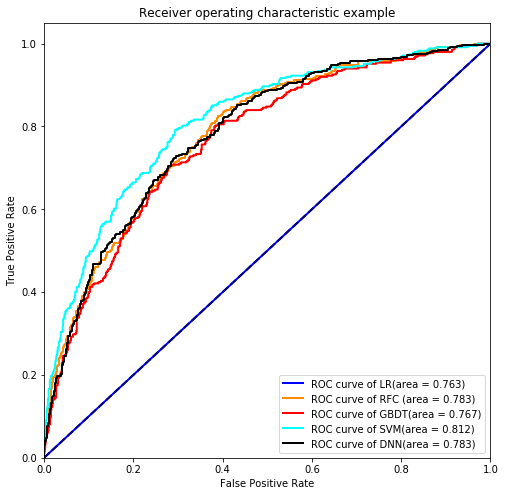

In [40]:
plt.figure(figsize=(8,8))

plt.plot(fpr_train_lr, fpr_train_lr, color='blue',lw=2, label='ROC curve of LR(area = %0.3f)' % auc_train_lr) #假正率为横坐标，真正率为纵坐标做曲线
plt.plot(fpr_train_rfc, tpr_train_rfc, color='darkorange',lw=2, label='ROC curve of RFC (area = %0.3f)' % auc_train_rfc) 
plt.plot(fpr_train_svm, tpr_train_svm, color='red',lw=2, label='ROC curve of GBDT(area = %0.3f)' % auc_train_svm) 
plt.plot(fpr_train_xgb, tpr_train_xgb, color='cyan',lw=2, label='ROC curve of SVM(area = %0.3f)' % auc_train_xgb) 
plt.plot(fpr_train_dnn, tpr_train_dnn, color='black',lw=2, label='ROC curve of DNN(area = %0.3f)' % auc_train_dnn)


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

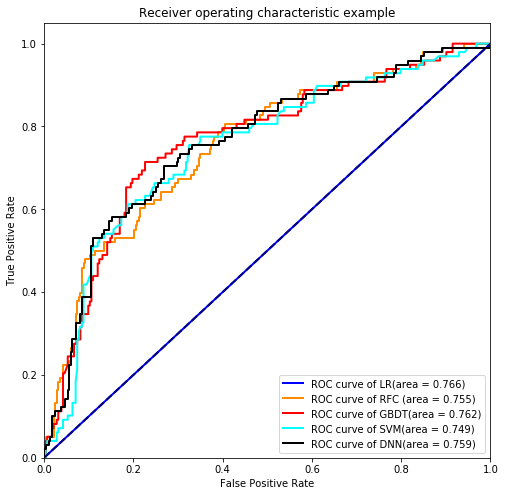

In [41]:
plt.figure(figsize=(8,8))

plt.plot(fpr_test_lr, fpr_test_lr, color='blue',lw=2, label='ROC curve of LR(area = %0.3f)' % auc_test_lr) #假正率为横坐标，真正率为纵坐标做曲线
plt.plot(fpr_test_rfc, tpr_test_rfc, color='darkorange',lw=2, label='ROC curve of RFC (area = %0.3f)' % auc_test_rfc) 
plt.plot(fpr_test_svm, tpr_test_svm, color='red',lw=2, label='ROC curve of GBDT(area = %0.3f)' % auc_test_svm) 
plt.plot(fpr_test_xgb, tpr_test_xgb, color='cyan',lw=2, label='ROC curve of SVM(area = %0.3f)' % auc_test_xgb) 
plt.plot(fpr_test_dnn, tpr_test_dnn, color='black',lw=2, label='ROC curve of DNN(area = %0.3f)' % auc_test_dnn)


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [42]:
dataset = pd.read_csv('HIAT.csv', header=0)


In [43]:
y_test_proba_HIAT = dataset.iloc[:,1]
y_test_proba_THRIVE = dataset.iloc[:,2]

In [44]:

fpr_test_hiat, tpr_test_hiat, thresholds = roc_curve(y_test, y_test_proba_HIAT)
fpr_test_thrive, tpr_test_thrive, thresholds = roc_curve(y_test, y_test_proba_THRIVE)

auc_test_hiat = auc(fpr_test_hiat, tpr_test_hiat)
auc_test_thrive = auc(fpr_test_thrive, tpr_test_thrive)

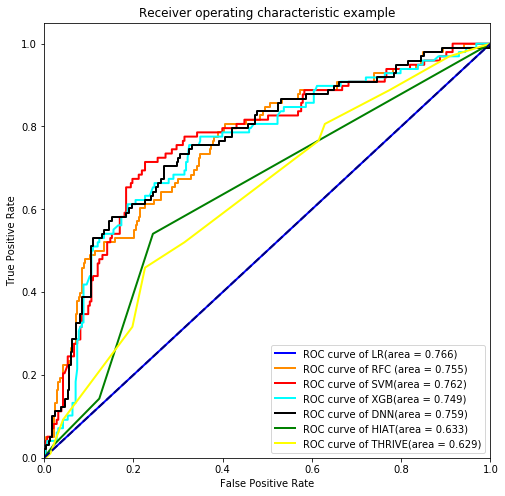

In [45]:
plt.figure(figsize=(8,8))

plt.plot(fpr_test_lr, fpr_test_lr, color='blue',lw=2, label='ROC curve of LR(area = %0.3f)' % auc_test_lr) 
plt.plot(fpr_test_rfc, tpr_test_rfc, color='darkorange',lw=2, label='ROC curve of RFC (area = %0.3f)' % auc_test_rfc) 
plt.plot(fpr_test_svm, tpr_test_svm, color='red',lw=2, label='ROC curve of SVM(area = %0.3f)' % auc_test_svm) 
plt.plot(fpr_test_xgb, tpr_test_xgb, color='cyan',lw=2, label='ROC curve of XGB(area = %0.3f)' % auc_test_xgb) 
plt.plot(fpr_test_dnn, tpr_test_dnn, color='black',lw=2, label='ROC curve of DNN(area = %0.3f)' % auc_test_dnn)
plt.plot(fpr_test_hiat, tpr_test_hiat, color='green',lw=2, label='ROC curve of HIAT(area = %0.3f)' % auc_test_hiat)
plt.plot(fpr_test_thrive, tpr_test_thrive, color='yellow',lw=2, label='ROC curve of THRIVE(area = %0.3f)' % auc_test_thrive)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [46]:
def plot_decision_curve(Model_Name_List, x_data, y_data):
    '''
    Model_Name_List:e.g：Model_Name_List = [(rf, 'RF'),(dnn,'DNN')]
    '''
    plt.figure(figsize=(6.4, 4.8),dpi=300)
    
    for model, name in Model_Name_List:
        if name == 'DNN':
            proba_model = model.predict(x_data)
            y_proba = np.copy(proba_model)           
        else:
            proba_model = model.predict_proba(x_data)
            y_proba = np.copy(proba_model[:, 1])
        
        #print(name)
        Y = y_data   
        pt_arr = []           
        net_bnf_arr = []      
        jiduan_arr = []       
        y_proba = y_proba.ravel()  
        for i in range(0,100,1):
            pt = i /100   
            #compute TP FP
            y_pred = np.zeros(y_proba.shape[0])  
            for j in range(y_proba.shape[0]):          
                if y_proba[j] >= pt:
                    y_pred[j] = 1
                else:
                    y_pred[j] = 0

            a=confusion_matrix(Y,y_pred)
            TP=a[1,1]
            FP=a[0,1]
            net_bnf = (TP-(FP * pt/(1-pt)) )/Y.shape[0]    
            #print('pt {}, TP {}, FP {}, net_bf {}'.format(pt,TP,FP,net_bnf))
            pt_arr.append(pt)
            net_bnf_arr.append(net_bnf)
            #Y = Y.ravel()
            jiduan = (np.sum(Y)-(len(Y)-np.sum(Y))*pt/(1-pt))/len(Y) 
            jiduan_arr.append(jiduan)
        
        
        plt.plot(pt_arr, net_bnf_arr, lw=1, linestyle='-',label=name)
        
    
    plt.plot(pt_arr, np.zeros(len(pt_arr)), color='k', lw=1, linestyle='--',label='None')   

    
    plt.plot(pt_arr, jiduan_arr, color='b', lw=1, linestyle='dotted',label='All')

    plt.xlim([0.0, 0.5])
    plt.ylim([-0.1, 0.3])
    plt.xlabel('Threshold Probability')
    plt.ylabel('Net Benefit')
    plt.title('Decision Curve Analysis of Models')
    plt.legend(loc="right")
    plt.show()

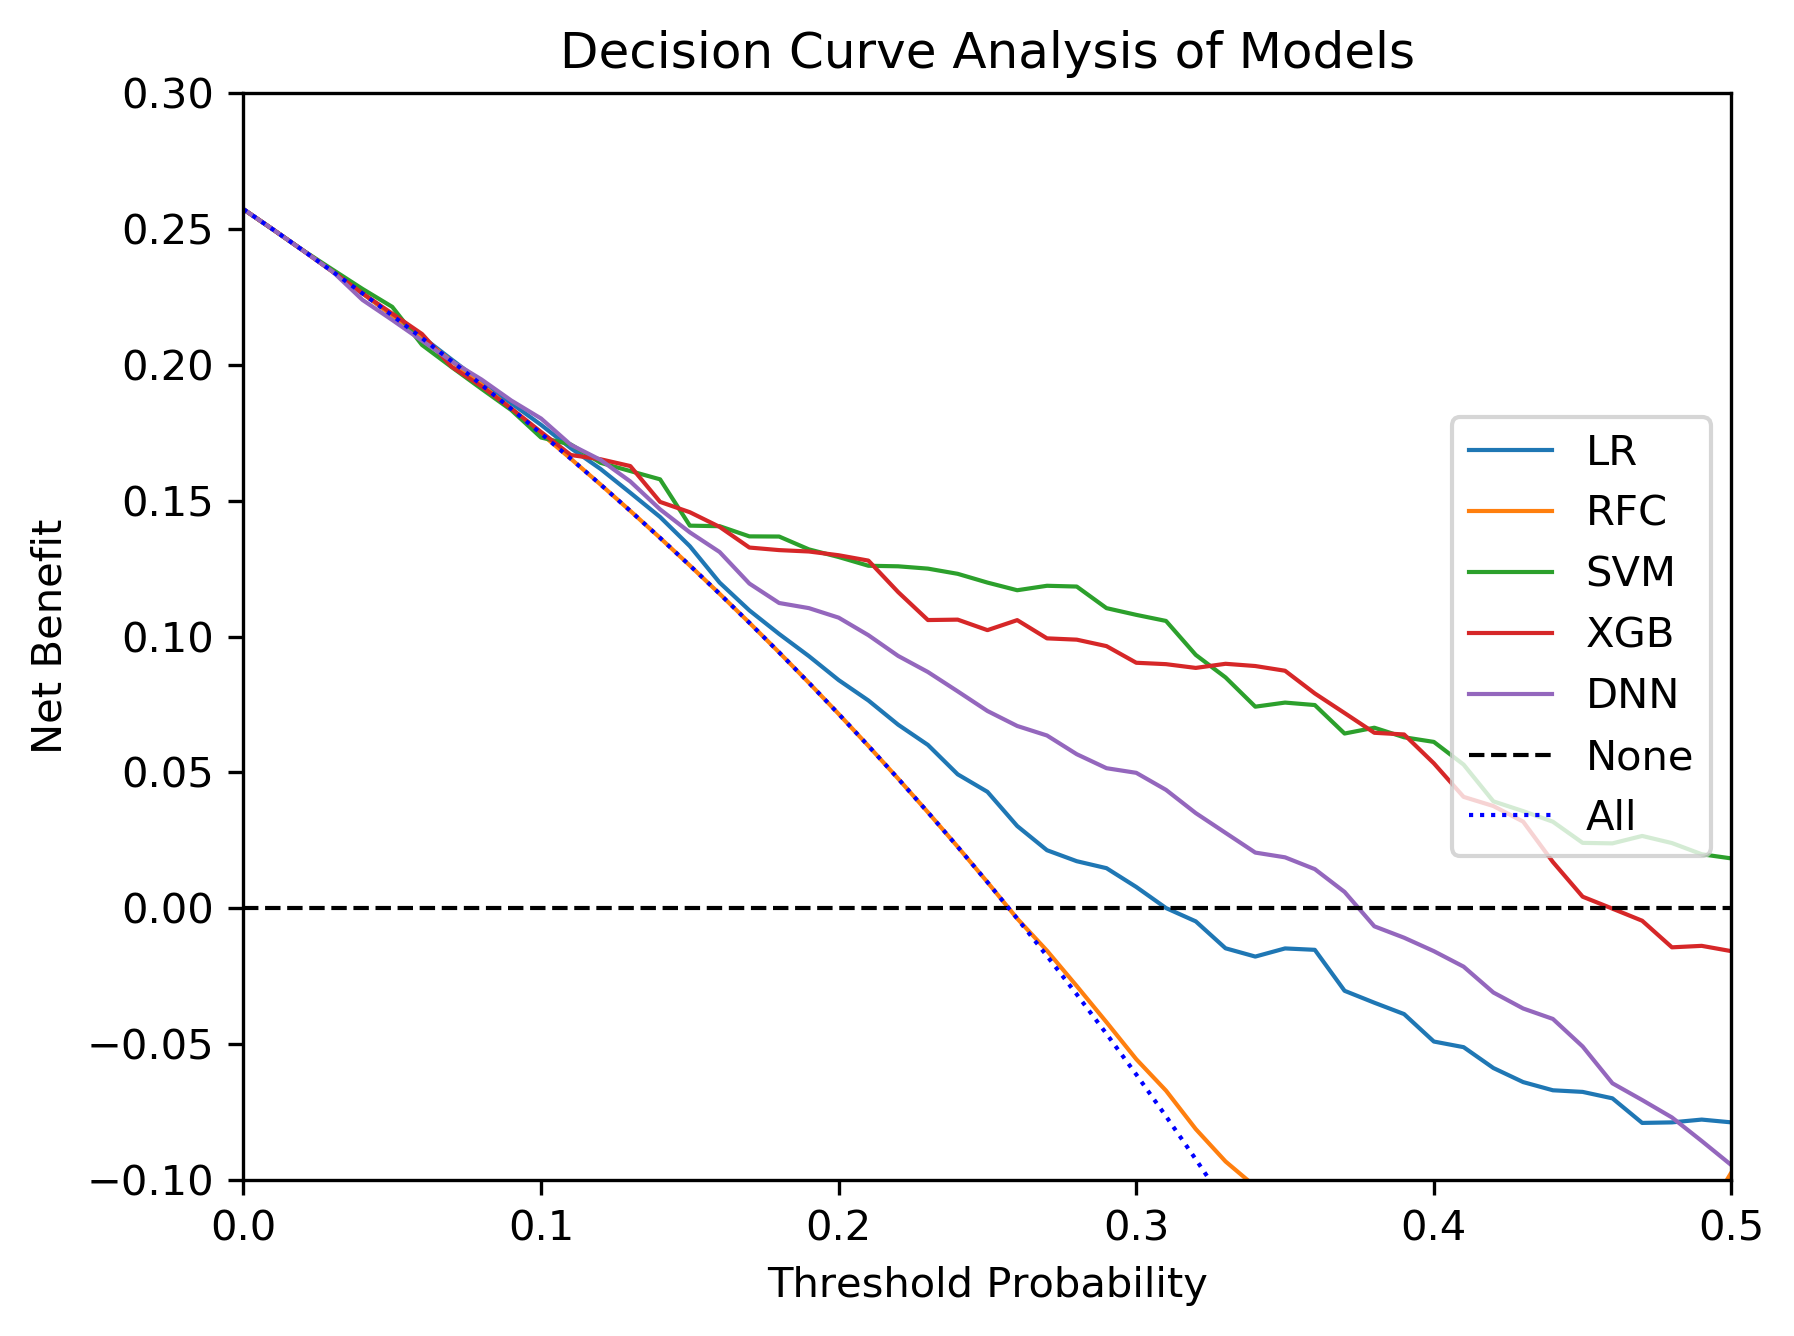

In [47]:
Model_Name_List = [(lr, 'LR'),(rfc1, 'RFC'),(svm, 'SVM'),(xgb, 'XGB'),(stroke, 'DNN')]
plot_decision_curve(Model_Name_List,x_test_standard1, y_test)

In [48]:
from sklearn.datasets import make_classification as mc
from sklearn.metrics import brier_score_loss 
from sklearn.calibration import calibration_curve 
from sklearn.linear_model import LinearRegression

In [49]:
name = ["LR","RFC","SVM",'XGB','DNN']
name1 = ["LR","RFC","SVM",'XGB']

LR:
	Brier: 0.221 slope:0.805 intercept:-0.129
RFC:
	Brier: 0.228 slope:1.533 intercept:-0.488
SVM:
	Brier: 0.159 slope:0.935 intercept:0.035
XGB:
	Brier: 0.165 slope:0.879 intercept:0.068
DNN:
	Brier: 0.227 slope:0.576 intercept:-0.030


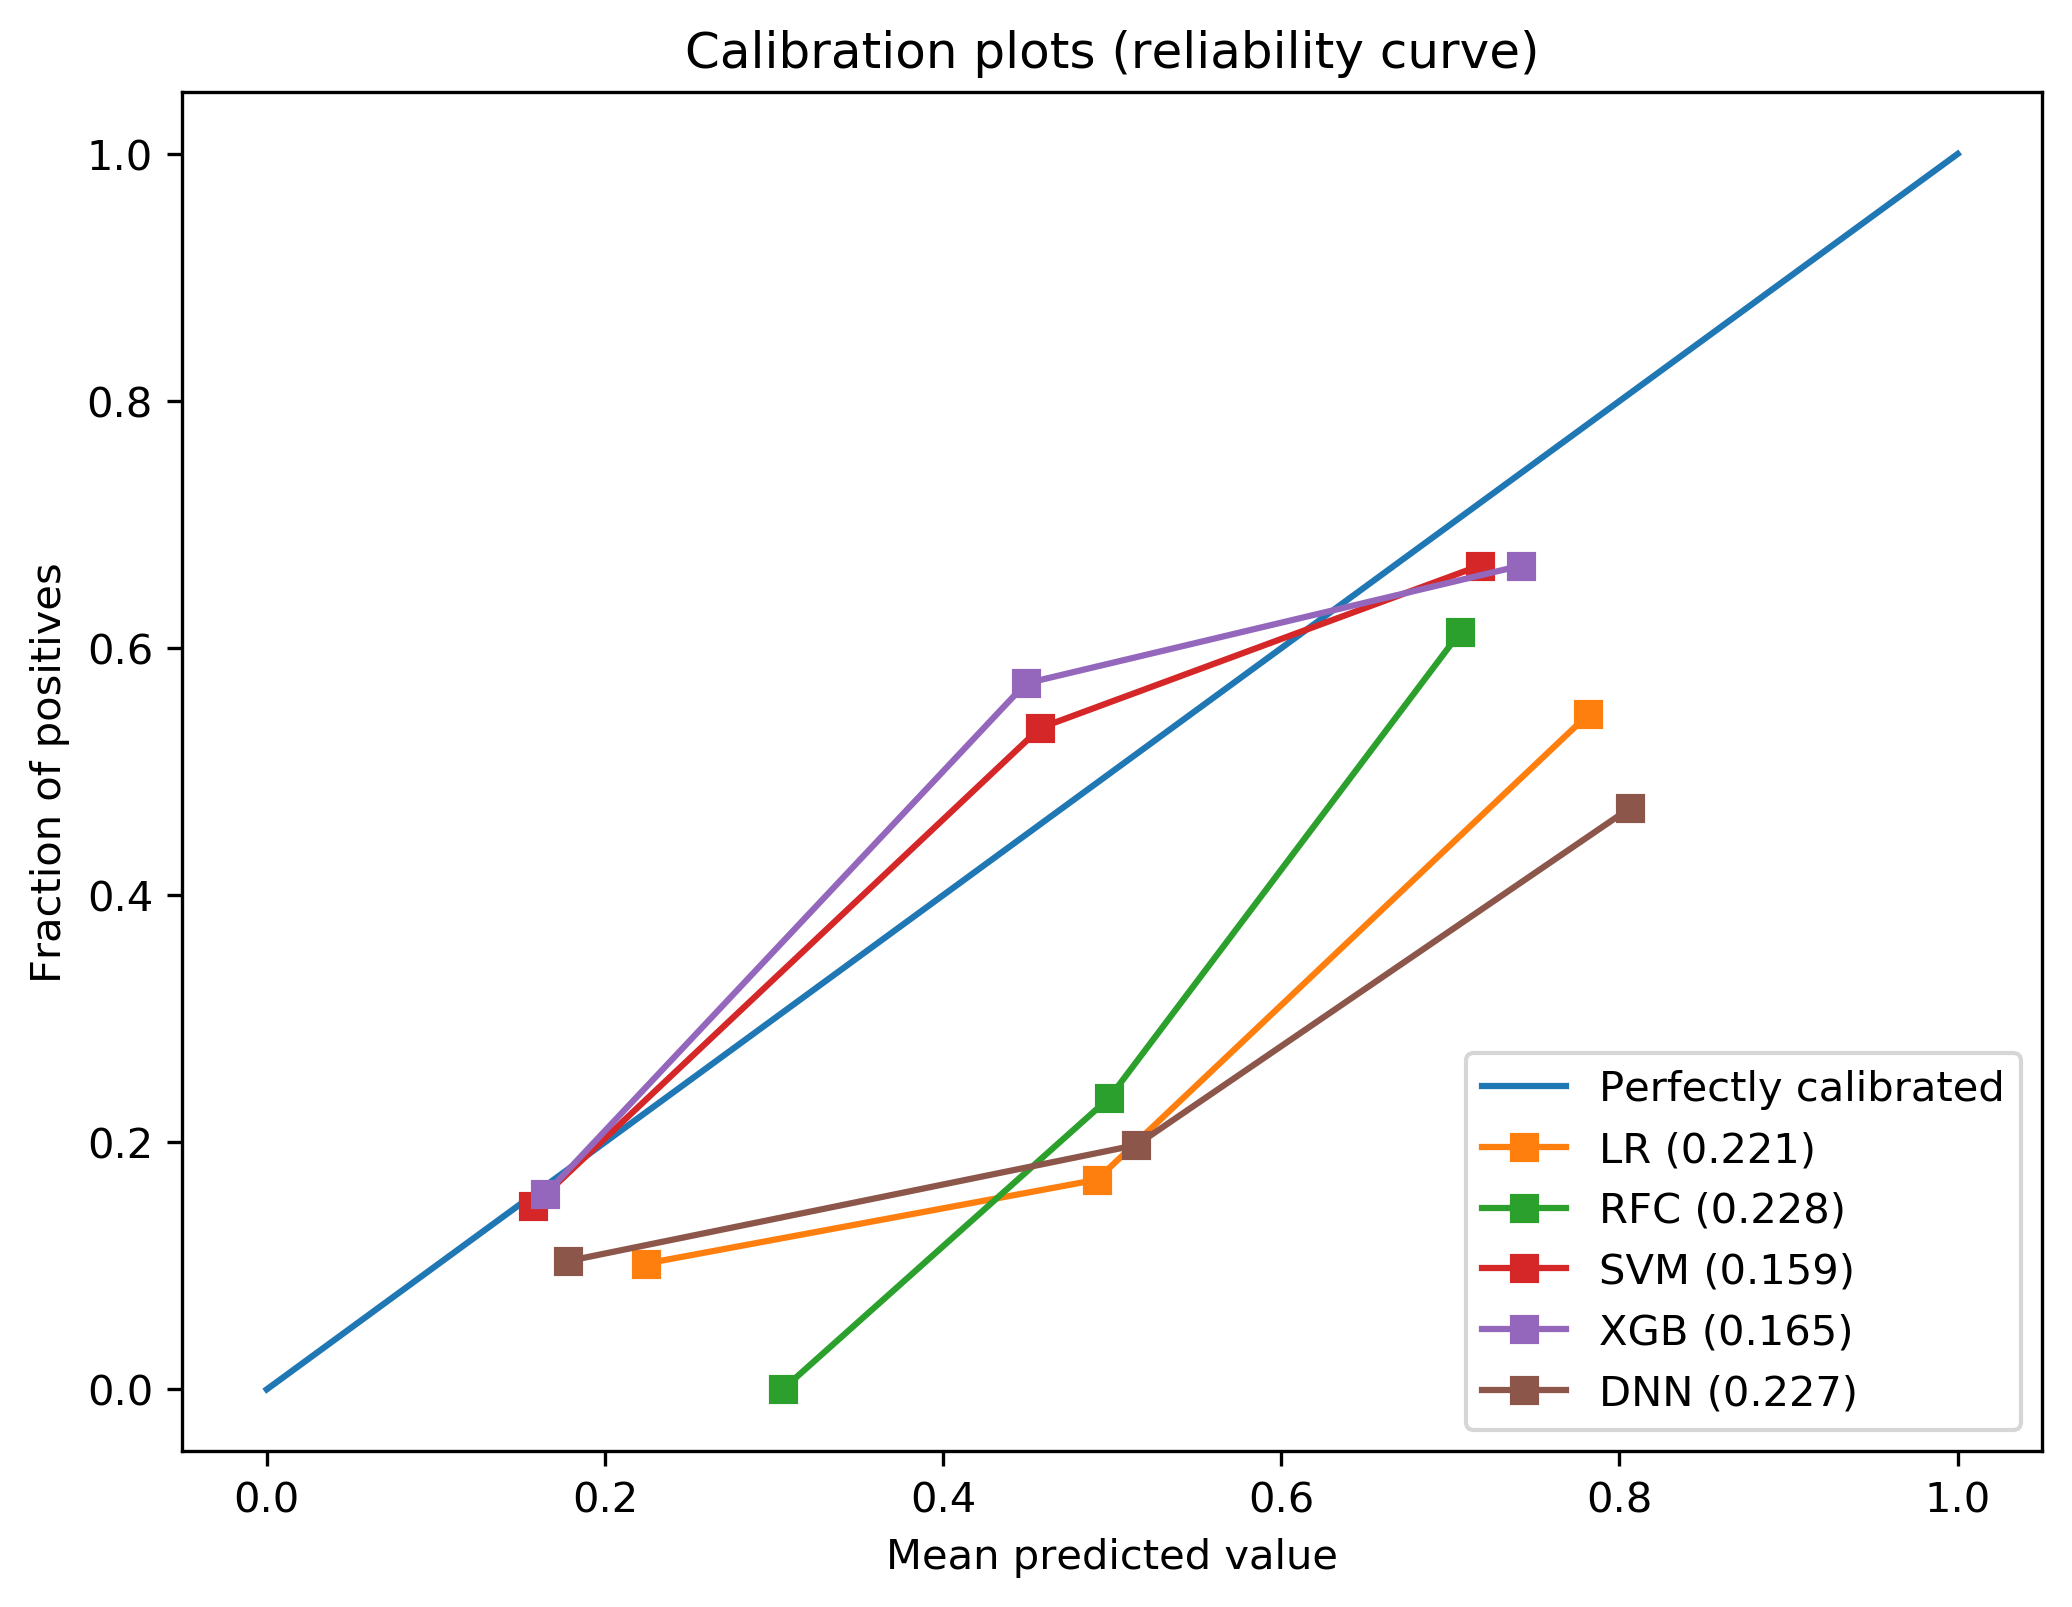

In [50]:
#fraction_of_positives trueproba, mean_predicted_value predproba.
plt.figure(figsize=(8,6),dpi=300)
plt.plot([0,1],[0,1],label = "Perfectly calibrated") 
for clf,name_ in zip([lr,rfc1,svm,xgb,stroke],name):
    
    
    if name_ == 'DNN':        
        proba_pos = clf.predict(x_test_standard1)
    else:                
        proba_pos = clf.predict_proba(x_test_standard1)[:, 1]
    
    clf_score = brier_score_loss(y_test, proba_pos)
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, proba_pos, n_bins=3)
    model= LinearRegression()
    model.fit(mean_predicted_value.reshape(-1,1),fraction_of_positives.reshape(-1,1))
    print("%s:" % name_)
    print("\tBrier: %1.3f" % (clf_score),'slope:%1.3f'%model.coef_ ,'intercept:%1.3f'%model.intercept_)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-",label="%s (%1.3f)" % (name_, clf_score))

plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots (reliability curve)')

plt.show()
